In [5]:
import os
import cv2
import numpy as np
import pandas as pd

# #Change this value based on your preferences
train_dir = "./jellyfish_data/Train_Test_Valid/Train"
train_dataframe = pd.DataFrame(columns=["path", "class"])

In [6]:
for class_name in os.listdir(train_dir):
  class_dir = os.path.join(train_dir, class_name)
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    train_dataframe.loc[len(train_dataframe.index)] = [image_path, class_name]

In [7]:
train_dataframe

,path,class
0,./jellyfish_data/Train_Test_Valid/Train\barrel...,barrel_jellyfish
1,./jellyfish_data/Train_Test_Valid/Train\barrel...,barrel_jellyfish
2,./jellyfish_data/Train_Test_Valid/Train\barrel...,barrel_jellyfish
3,./jellyfish_data/Train_Test_Valid/Train\barrel...,barrel_jellyfish
4,./jellyfish_data/Train_Test_Valid/Train\barrel...,barrel_jellyfish
...,...,...
895,./jellyfish_data/Train_Test_Valid/Train\Moon_j...,Moon_jellyfish
896,./jellyfish_data/Train_Test_Valid/Train\Moon_j...,Moon_jellyfish
897,./jellyfish_data/Train_Test_Valid/Train\Moon_j...,Moon_jellyfish
898,./jellyfish_data/Train_Test_Valid/Train\Moon_j...,Moon_jellyfish


In [8]:
xdim = 224
ydim = 224

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_datagen=ImageDataGenerator(rescale=1./255.,
                               horizontal_flip = True,
                                vertical_flip = True,
                               rotation_range = 5)

In [10]:
X = np.array(train_dataframe["path"])

Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2378 - loss: 2.0802 - val_accuracy: 0.3611 - val_loss: 1.6095
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3179 - loss: 1.6634 - val_accuracy: 0.2889 - val_loss: 1.7186
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4214 - loss: 1.4483 - val_accuracy: 0.3833 - val_loss: 1.4452
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4753 - loss: 1.2918 - val_accuracy: 0.3833 - val_loss: 1.4482
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4896 - loss: 1.2443 - val_accuracy: 0.4889 - val_loss: 1.2625
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5739 - loss: 1.1029 - val_accuracy: 0.4778 - val_loss: 1.2606
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5901 - loss: 1.0460 - val_accuracy: 0.4889 - val_loss: 1.2038
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6268 - loss: 0.9585 - val_accuracy: 0.5278 - val_loss:

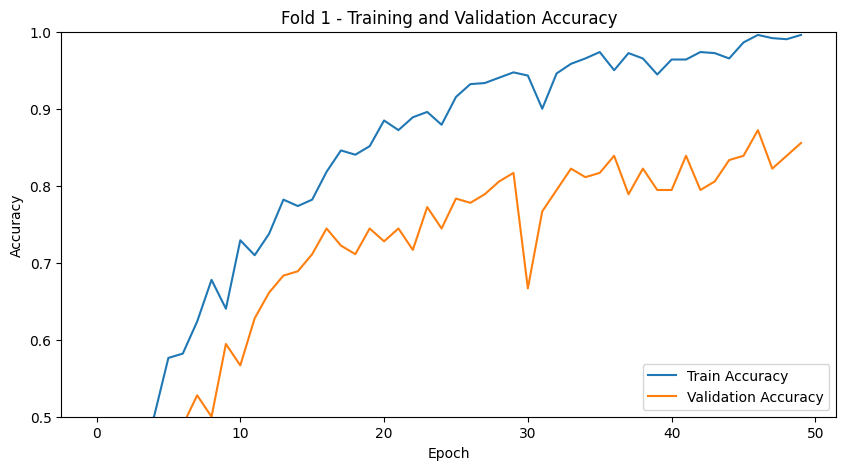

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.8431 - loss: 0.4584
Validation Accuracy for fold 1: 82.78%
Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2309 - loss: 2.0320 - val_accuracy: 0.2111 - val_loss: 1.8030
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3035 - loss: 1.6143 - val_accuracy: 0.3278 - val_loss: 1.6632
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4029 - loss: 1.4656 - val_accuracy: 0.3556 - val_loss: 1.5602
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4934 - loss: 1.2702 - val_accuracy: 0.4333 - val_loss: 1.4689
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4871 - loss: 1.2673 - val_accuracy: 0.4667 - val_loss: 1.4067
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5738 - loss: 1.0979 - val_accuracy: 0.5000 - val_loss: 1.2565
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5896 - loss: 1.0601 - val_accuracy: 0.5111 - val_loss: 1.3382
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6567 - loss: 0.9018 - val_accuracy: 0.5500 - val_loss:

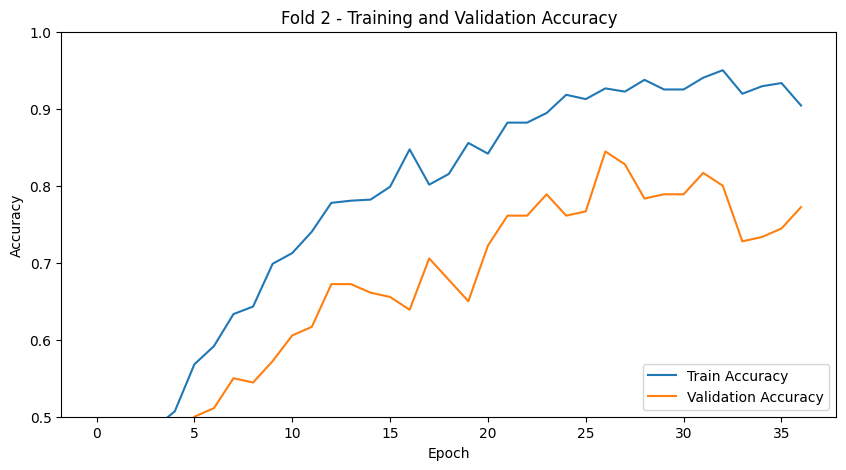

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.8166 - loss: 0.5994
Validation Accuracy for fold 2: 82.78%
Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.1884 - loss: 2.1556 - val_accuracy: 0.3111 - val_loss: 1.6440
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3531 - loss: 1.5403 - val_accuracy: 0.3500 - val_loss: 1.5194
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4497 - loss: 1.3734 - val_accuracy: 0.4389 - val_loss: 1.4090
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5077 - loss: 1.2211 - val_accuracy: 0.4500 - val_loss: 1.3690
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5047 - loss: 1.2276 - val_accuracy: 0.4556 - val_loss: 1.3051
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6052 - loss: 1.0522 - val_accuracy: 0.5333 - val_loss: 1.1394
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5982 - loss: 1.0662 - val_accuracy: 0.5722 - val_loss: 1.0890
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6230 - loss: 0.9613 - val_accuracy: 0.6111 - val_loss:

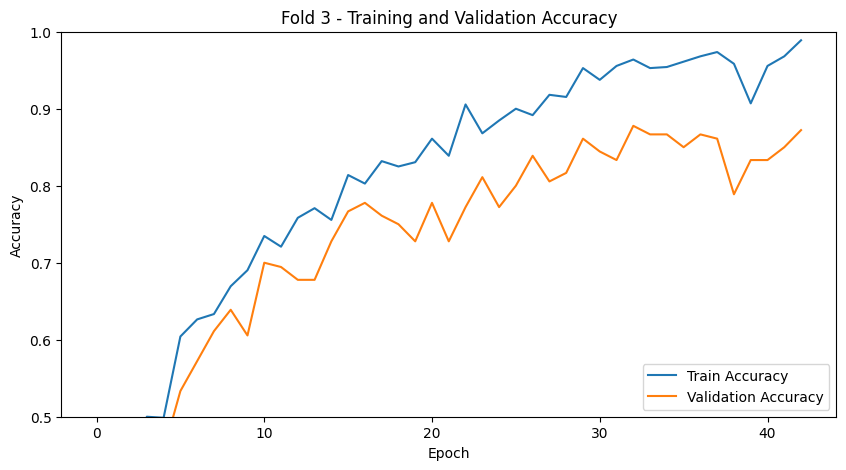

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.8840 - loss: 0.3640
Validation Accuracy for fold 3: 88.33%
Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2051 - loss: 2.1180 - val_accuracy: 0.3000 - val_loss: 1.6603
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2532 - loss: 1.7026 - val_accuracy: 0.3611 - val_loss: 1.5141
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3068 - loss: 1.5654 - val_accuracy: 0.4500 - val_loss: 1.3605
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4406 - loss: 1.3797 - val_accuracy: 0.4667 - val_loss: 1.2595
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5279 - loss: 1.2258 - val_accuracy: 0.4889 - val_loss: 1.2709
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5324 - loss: 1.2368 - val_accuracy: 0.5444 - val_loss: 1.1445
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6060 - loss: 1.0457 - val_accuracy: 0.5667 - val_loss: 1.1614
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6258 - loss: 0.9714 - val_accuracy: 0.5944 - val_loss:

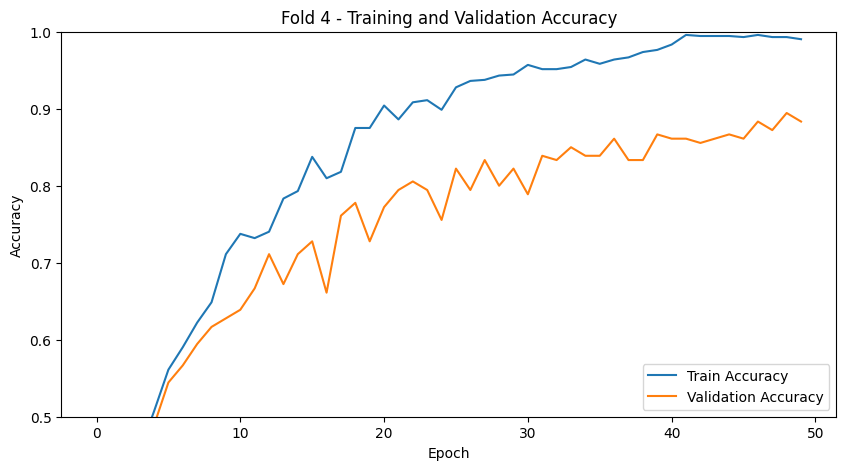

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.9282 - loss: 0.2794
Validation Accuracy for fold 4: 92.78%
Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2212 - loss: 2.0583 - val_accuracy: 0.3056 - val_loss: 1.6257
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2978 - loss: 1.6288 - val_accuracy: 0.3444 - val_loss: 1.4958
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3873 - loss: 1.4566 - val_accuracy: 0.4722 - val_loss: 1.2863
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4424 - loss: 1.3413 - val_accuracy: 0.4611 - val_loss: 1.2466
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4965 - loss: 1.2580 - val_accuracy: 0.5833 - val_loss: 1.1051
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5219 - loss: 1.1992 - val_accuracy: 0.5056 - val_loss: 1.1906
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5466 - loss: 1.0893 - val_accuracy: 0.5611 - val_loss: 1.0841
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5899 - loss: 1.0037 - val_accuracy: 0.5667 - val_loss:

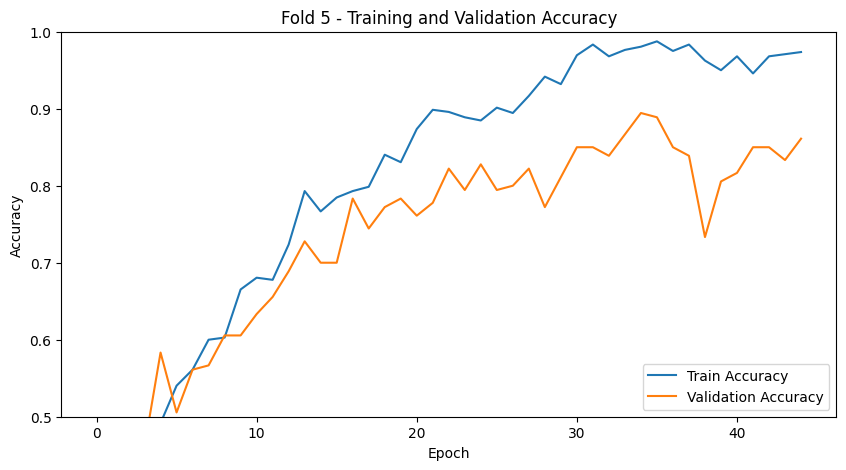

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.8484 - loss: 0.4986
Validation Accuracy for fold 5: 83.33%
Average Cross-Validation Accuracy: 86.00% ± 3.98%


In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

kf = KFold(n_splits=5, random_state=1, shuffle=True)

cvScores = []
i = 1
for train_index, test_index in kf.split(X):
    print(f"Fold: {i} ==================================================================")
    
    # 폴드 내 훈련 및 테스트 데이터 설정
    train_data = X[train_index]
    test_data = X[test_index]
    train_dataframe_inside = train_dataframe.loc[train_dataframe["path"].isin(list(train_data))]
    validation_dataframe = train_dataframe.loc[train_dataframe["path"].isin(list(test_data))]
    
    labels = list(train_dataframe_inside["class"].unique())
    
    # 데이터 제너레이터 설정
    train_generator = main_datagen.flow_from_dataframe(
        dataframe=train_dataframe_inside,
        directory=None,
        x_col="path",
        y_col="class",
        class_mode="categorical",
        classes=labels,
        target_size=(xdim, ydim),
        color_mode="rgb",
        batch_size=32
    )
    
    validation_generator = main_datagen.flow_from_dataframe(
        dataframe=validation_dataframe,
        directory=None,
        x_col="path",
        y_col="class",
        class_mode="categorical",
        classes=labels,
        target_size=(xdim, ydim),
        color_mode="rgb",
        batch_size=32
    )
    
    # 모델 정의
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(xdim, ydim, 3)),  # Input 레이어 추가
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4,4), padding='same'),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4,4), padding='same'),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4,4), padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 조기 종료 콜백 설정
    early_stopping = EarlyStopping(
        monitor='val_accuracy',         # 평가할 지표 (val_loss를 사용할 수도 있음)
        patience=10,                    # 10 에포크 동안 개선이 없으면 학습 중단
        restore_best_weights=True       # 가장 좋은 가중치를 복원
    )
    
    # 모델 학습
    model_history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping]  # 조기 종료 콜백 추가
    )
    
    # 학습 결과 시각화
    plt.figure(figsize=(10,5))
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title(f'Fold {i} - Training and Validation Accuracy')
    plt.show()

    # 폴드 성능 평가
    scores = model.evaluate(validation_generator)
    cvScores.append(scores[1] * 100)
    print(f"Validation Accuracy for fold {i}: {scores[1] * 100:.2f}%")
    
    i += 1

# 전체 평균 정확도 출력
print("===================================================================")
print(f"Average Cross-Validation Accuracy: {np.mean(cvScores):.2f}% ± {np.std(cvScores):.2f}%")



In [15]:
avgScores = np.mean(cvScores)
stdScores = np.std(cvScores)
print(f"Average KFold Cross Validation Score: {avgScores}")
print(f"Standard Deviation KFold Cross Validation Score: {stdScores}")

Average KFold Cross Validation Score: 86.00000023841858
Standard Deviation KFold Cross Validation Score: 3.9814374124489547
